## LangGraph - Adding a basic chatbot

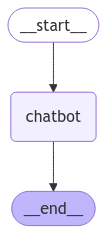

In [8]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_ollama import ChatOllama

# define graph builder
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]
graph_builder = StateGraph(State)


# define llm model to use
model_name = "llama3.2:latest"
llm = ChatOllama(
    model=model_name,
    temperature=0
)


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
# graph_builder.add_edge(START, "chatbot")
# graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

# Visualize the graph
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [9]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        # print(event)
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break
    
    

Assistant: One of the most iconic and must-visit places in Seattle is:

**The Space Needle**

Located at the top of Queen Anne Hill, the Space Needle offers breathtaking 360-degree views of the city, Puget Sound, and surrounding mountains. The tower stands at an impressive 605 feet tall and was completed in 1962.

Visitors can enjoy stunning vistas from the observation deck on the 52nd floor, which features large windows, interactive exhibits, and a rotating restaurant called SkyCity. On clear days, you can see as far as Mount Rainier, the Olympic Mountains, and the Cascade Range.

The Space Needle is an iconic symbol of Seattle and offers an unforgettable experience for visitors of all ages. It's a great place to start or end your day in Seattle, and it's easily accessible by public transportation or ride-sharing services.

Tips:

* Buy tickets online in advance to avoid long wait times.
* Consider visiting during sunset or twilight for the most stunning views.
* Don't forget to take 

## Add tool to graph

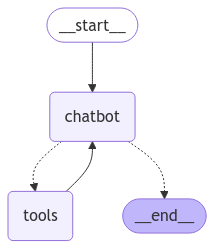

In [10]:
import json
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama
from langchain_core.tools import tool
from langchain_core.messages import ToolMessage

# Define State for the graph
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)


# Define LLM model
model_name = "llama3.2:latest"
llm = ChatOllama(
    model=model_name,
    temperature=0
)

# Define and register the `search` tool
@tool
def search(message):
    """
    Searches or find any SingleStore information. If its a query related to SingleStore, use this tool and do not use your own knowledge.

    Args:
        message (str): The message or query to search for.

    Returns:
        str: A string containing information about the given message.
    """
    return f"Demo of the tool - SingleStore search result for: {message}. There are 100 engineers. We are a group of passionate employees who love working on challenging distributed problems"

model_with_tool = llm.bind_tools([search])

# Chatbot node
def chatbot(state: State):
    messages = state["messages"]
    # # Add the system message if not already present
    # if not any(message["role"] == "system" for message in messages):
    #     messages.append(system_message)
    # Invoke the LLM
    return {"messages": [model_with_tool.invoke(messages)]}


# Define BasicToolNode to process tool calls
class BasicToolNode:
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

tool_node = BasicToolNode(tools=[search])
graph_builder.add_node("tools", tool_node)

# Add chatbot node
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")

# Conditional routing
def route_tools(state: State):
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", END: END},
)
graph_builder.add_edge("tools", "chatbot")

# Compile the graph
graph = graph_builder.compile()

# Visualization (optional)
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass


In [11]:
def stream_graph_updates(user_input: str):
    """
    Function to stream updates from the LangGraph graph.
    
    Args:
        user_input (str): The user's input message to process.
    """
    # Construct the state with properly formatted messages
    config = {"configurable": {"thread_id": "1"}}
    state = {
        "messages": [{"role": "user", "content": user_input}]
    }
    try:
        for event in graph.stream(state):
            for value in event.values():
                print("Assistant:", value["messages"][-1].content)
    except Exception as e:
        print(f"Error in streaming graph updates: {e}")


# Main loop for user interaction
while True:
    try:
        # Get user input
        user_input = input("User: ").strip()
        
        # Exit condition
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        # Process user input
        stream_graph_updates(user_input)
    except EOFError:
        # Handle case where `input` is not available (e.g., in some environments)
        fallback_input = "What do you know about LangGraph?"
        print("User: " + fallback_input)
        stream_graph_updates(fallback_input)
        break
    except Exception as e:
        # Catch unexpected errors to prevent the loop from crashing
        print(f"An error occurred: {e}")

Assistant: 
Assistant: "Demo of the tool - SingleStore search result for: How many employees are in SingleStore. There are 100 engineers. We are a group of passionate employees who love working on challenging distributed problems"
Assistant: There are approximately 100 engineers at SingleStore, a company that specializes in developing and supporting an open-source relational database management system called ClusterDDB (also known as UDB). The team is dedicated to creating a highly available, scalable, and secure database solution for modern applications.
Goodbye!


## Adding memory to the chatbot

This time it uses framework classes without implementing the ToolNode

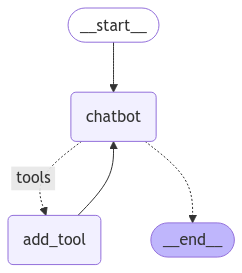

In [12]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

from typing import Annotated
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_ollama import ChatOllama
from langchain_core.tools import tool


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


# Define LLM model
model_name = "llama3.2:latest"
llm = ChatOllama(
    model=model_name,
    temperature=0
)

# Define and register the `add` tool
@tool
def add(a: int, b: int):
    """
    Adds two integers together. Do not use your own knowledge for this task. Do not call this tool unless you are sure it is an addition operation.

    Args:
        a (int): The first integer to add.
        b (int): The second integer to add.

    Returns:
        int: The sum of the two integers.
    """
    return a + b

llm_with_tools = llm.bind_tools([add])


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[add])
graph_builder.add_node("add_tool", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {"tools": "add_tool", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("add_tool", "chatbot")

graph = graph_builder.compile(checkpointer=memory)
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
config1 = {"configurable": {"thread_id": "1"}}
config2 = {"configurable": {"thread_id": "2"}}
user_input = "Hi! My name is Vijay. How is Seattle?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config1,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! My name is Vijay. How is Seattle?
================================== Ai Message ==================================
Tool Calls:
  add (ee4282b3-b98d-446d-a44d-6023ddc94659)
 Call ID: ee4282b3-b98d-446d-a44d-6023ddc94659
  Args:
    a: 0
    b: 0
================================= Tool Message =================================
Name: add

0
================================== Ai Message ==================================

Hello Vijay, I'm happy to help you with your question about Seattle!

Seattle's weather can be quite unpredictable, but generally, it's known for being rainy and overcast. However, the city also experiences a lot of sunshine during the summer months.

If you're planning a visit to Seattle, I recommend checking the forecast before you go to get a better idea of what to expect. The city has plenty of indoor attractions and activities to enjoy, such as museums, coffee shops, and music venues

In [14]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config1,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================
Tool Calls:
  add (22690036-68ab-4b2f-b39d-6fda3228a051)
 Call ID: 22690036-68ab-4b2f-b39d-6fda3228a051
  Args:
    a: 0
    b: 7
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

Hello Vijay! I remember your name, and I'm happy to chat with you again.

So, to recap, Seattle's weather is generally rainy and overcast, but it also has plenty of sunshine during the summer months. If you're planning a visit, be sure to check the forecast beforehand.

Is there anything else on your mind that you'd like to talk about or ask about Seattle? I'm all ears!


In [15]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config2, # Using different config
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================
Tool Calls:
  add (54b3e712-9cab-4699-bb38-f464ceee9c48)
 Call ID: 54b3e712-9cab-4699-bb38-f464ceee9c48
  Args:
    a: 5
    b: 7
================================= Tool Message =================================
Name: add

12
================================== Ai Message ==================================

The answer to your original question is: The sum of 5 and 7 is 12.


## Human in the loop

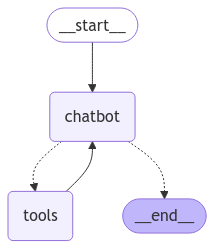

In [17]:
from typing import Annotated

from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_ollama import ChatOllama

from langgraph.types import Command, interrupt


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

from typing import List

@tool
def validate_user(user_id: int, addresses: List[str]) -> bool:
    """Validate user using historical addresses.

    Args:
        user_id (int): the user ID.
        addresses (List[str]): Previous addresses as a list of strings.
    """
    return True
tools = [validate_user, human_assistance]
llm = ChatOllama(
    model=model_name,
    temperature=0,
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [18]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (4e6c5462-d7e1-4a48-ba01-93b7aaba3351)
 Call ID: 4e6c5462-d7e1-4a48-ba01-93b7aaba3351
  Args:
    query: expert guidance for building an AI agent


In [19]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [20]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (4e6c5462-d7e1-4a48-ba01-93b7aaba3351)
 Call ID: 4e6c5462-d7e1-4a48-ba01-93b7aaba3351
  Args:
    query: expert guidance for building an AI agent
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

It seems like we've got some great resources to get you started on building your AI agent.

LangGraph is a popular open-source framework for building and training neural networks, particularly well-suited for complex tasks such as reinforcement learning. Here are some key features that make it an excellent choice:

1.  **Modular Architecture**: LangGraph allows you to build and train mode

## Customizing state

In [21]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

In [22]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt


@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

In [23]:
from langchain_ollama import ChatOllama

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool

# Define and register the `search` tool
@tool
def search(message):
    """
    Searches or find any information related to SingleStore.

    Args:
        message (str): The message or query to search for.

    Returns:
        str: A string containing information about the given message.
    """
    return f"SingleStore version 8.7 may have been released in June 2024."

tools = [search, human_assistance]
llm = ChatOllama(
    model=model_name,
    temperature=0,
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [24]:
user_input = (
    "Can you look up when SingleStore 8.7 was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when SingleStore 8.7 was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================
Tool Calls:
  search (17664b58-ec4d-40cd-838c-ab9a30ce6538)
 Call ID: 17664b58-ec4d-40cd-838c-ab9a30ce6538
  Args:
    message: SingleStore 8.7 release date
================================= Tool Message =================================
Name: search

SingleStore version 8.7 may have been released in June 2024.
================================== Ai Message ==================================

According to my search, SingleStore version 8.7 was released in June 2024. Is there anything else I can help you with regarding this release or any other SingleStore-related query?
